#  Stacking for the estimation of Treatment Effects

In estimating the effect of a treatment, we would ideally like to know what the outcome $y_i$ would have been, had the treated not received treatment, and had the treated been left untreated.
This is almost always impossible as we will never be able to set up an experiment where each person in the treatment group has their exact twin in the control group, though some experimental setups may come close.
Another reason, specifically in marketing, is that a treatment (like a voucher for some online market) may be very expensive to offer to all or even one half of the sample.

There are however many ways to account for this. In an experimental setup, or a situation in which we have treated and untreated data, it of course is necessary to estimate the underlying distribution of the 'nuisance variables' $X_i$
In some models, we may also  estimate the _propensity score_ (the likelihood, given an observation's characteristics, to be treated, to avail of a treatment, or to sort themselves into the treatment group) $e_i$, in order to be able to extract the effect of the treatment while accounting for the varables that account for their being treated in the first place.
And of course it is not always possible to account for every variable which has an effect on the outcome, or even the treatment-control division.
The average effect of a treatment (the average difference between treatment and control), is more simple to study, especially in a randomized setup, but estimates of the effect of a treatment conditional on some other variables or characteristics are more difficult to study.
For this reason there exist several methods to apply machine learning to estimate (multivariate) distributions over treated and untreated groups to finally estimate a conditional average treatment effect over tranches of a population.

Machine learning models can vary in their advantages, disadvantages, tuning parameters, runtimes and robustness (especially given the underlying data), and for this reason it is of interest to this paper what effect an ensemble of methods can bring to the accuracy or robustness of an estimate of treatmenet effects.
For this reason, we will examine two methods of utilizing the estimates of several more or less out-of-the-box machine learning models in an ensemble, and examine how they perform on three different data distributions.

# I. Synthesizing data
In order to compare the predictive results of our models depending on the shape of the underlying data, and conclude upon the effectiveness of stacking for treatment effects in each situation we generate data according to the same process as *Nie X. and Wager S. (2018) 'Quasi-Oracle Estimation of Heterogeneous Treatment Effects'*. a library for generating different kinds of data specifically for the study of treatment effects is provided by `causalml` from uber (https://github.com/uber/causalml).

`causalml` provides an implementation of each data generating function as seen in Nie & Wager; each of these provides a data set of $X_i$ variables, propensity to be treated $e_i$ as a function of the $X_i$ (or as a random function, in some cases), and a treatment effect as a function of the $X_i$.
Generated datasets also have the advantage that we may generate as much data as we need in order to cross validate and otherwise test, with the guarantee that all the data generated comes from the same distribution. The `causalml` datasets also provide us with the true treatment effect and true outcome without treatment, so that we may be able to test the predicted $y_i$ and $\tau(X_i)$

From Nie and Wager we will use three datasets:
* A randomized trial - where the treatment and control groups are randomly split, where it is not necessary to estimate a propensity score as we can assume each observation has a 50% likelihood of being treated, and where the $X_i$ are a set or random normal variables, and the baseline outcome without treatment is `np.maximum(np.repeat(0.0, n), X[:, 0] + X[:, 1] + X[:, 2]) + np.maximum(np.repeat(0.0, n), X[:, 3] + X[:, 4])`
*"Difficult nuisance components and an easy treatment effect", where the $X_i$ are drawn from a random normal distribution: `X = np.random.uniform(size=n*p).reshape((n, -1))`, while the treatment effect is merely half the sum of the $x_1$, $x_2$ : `tau = (X[:, 0] + X[:, 1]) / 2`
*"Easy Propensity score and difficult baseline", where the assignment of treatment throughout the dataset is a simple function of the $X_i$, specifically: `e = 1/(1 + np.exp(X[:, 1] + X[:, 2]))`, while the $X_i$ are themselves random normals and the true outcome without treatment is difficult - `2 * np.log1p(np.exp(X[:, 0] + X[:, 1] + X[:, 2]))`

Below we plot the distribution of outcomes over treatment and control arms in each setup.

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
[MLENS] backend: threading


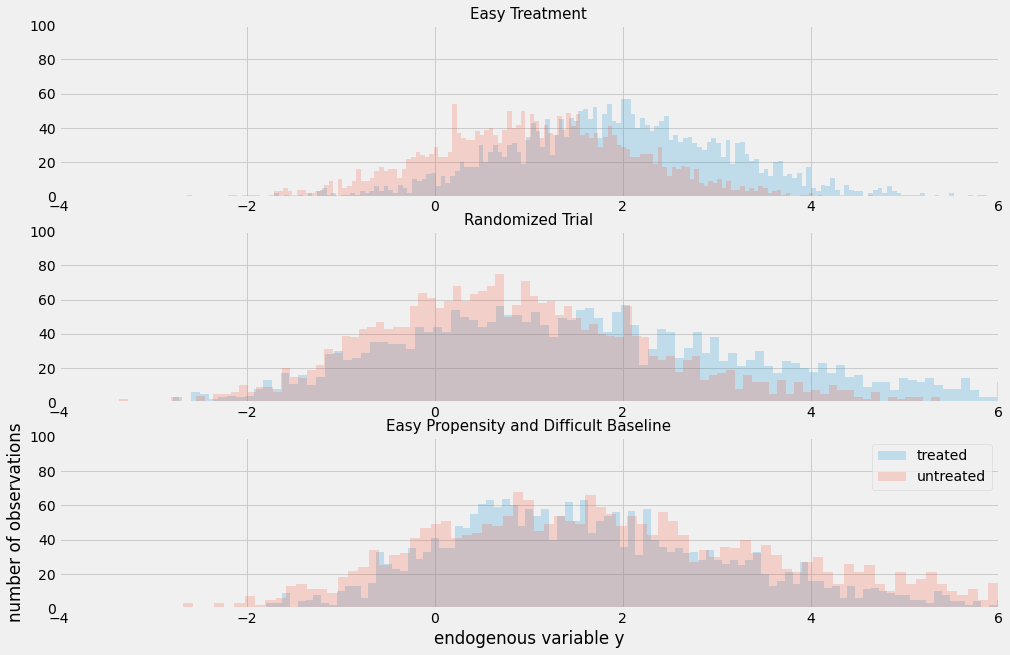

In [1]:
import matplotlib.pyplot as plt
from causalml.dataset import *
from mlens.ensemble import SuperLearner
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import data_gen
import simple_model
import stacking_helpers

y_easy, X_easy, w_easy, tau_easy, b_easy, e_easy = simulate_nuisance_and_easy_treatment(n=5000, p=5)
y_rand, X_rand, w_rand, tau_rand, b_rand, e_rand = simulate_randomized_trial(n=5000, p=5)
y_difficult, X_difficult, w_difficult, tau_difficult, b_difficult, e_difficult = simulate_easy_propensity_difficult_baseline(
    n=5000, p=5)

plt.figure(figsize=(15,10))
data_gen.treated_vs_untreated_plot(y_easy, w_easy, 'Easy Treatment', 311)
data_gen.treated_vs_untreated_plot(y_rand, w_rand, 'Randomized Trial', 312)
data_gen.treated_vs_untreated_plot(y_difficult, w_difficult, 'Easy Propensity and Difficult Baseline', 313)

plt.xlabel('endogenous variable y')
plt.ylabel('number of observations')
_ = plt.legend()
plt.show()

The randomized trial appears to show a slight difference in mean and variance of outcomes between treatment and control.
In the 'Setup A' of Nie and Wager ('easy treatment effect and difficult nuisance') we can see that the distribution of the treatment arm is just shifted to the right of the control.
In the last setup - 'Easy Propensity and Difficult Baseline', however, the difference in the outcome is unclear there seems to be no clear treatment effect just examining the distribution of Y.

# II. Grimmer, The 'S-Learner' - Simulations
The first setup we will examine for estimating the conditional average treatment effect (the average treatment effect of a group or subset of characteristics in the population) is one where the treatment effect is estimated by simple comparison of the treated against the untreated, with the same underlying $X_i$.
This involves training a machine learning model, which uses the treatment assignment variable as a dummy and then predicts the outcome $y_i$ in both the case of treated and untreated, to find the difference - equivalent to the treatmenet effect.

Grimmer, Messing, Westwood (2017) use this type of setup on political data with many categorical variables. (real-life data). They find that the ensemble method is better than any single model in all cases, sometimes much much better.
Nie and Wager compare treatment effect learners using (among other heterogeneous treatment effect estimators) the 'S-Learner'.

The S learner gets its name from Kunzel et al. (2018) (https://arxiv.org/abs/1706.03461) because it is a 'single' learner, which uses a single model - without accounting for propensity scores. and without training the treatment and control arms differently. The difference between this algorithm and the T learner, which learns each arm independently, is that the S learner can account for the covariance between assignment $w_i$ and the nuisance variables $X_i$.
The S learner (`BaseSRegressor()`) as implemented by `causalml` can be fed a machine learning model to estimate and predict the outcome $y_i$ in both cases, in order to compute a conditional treatment effect, and to provide confidence intervals for each estimate. Unfortunately, in order to stack estimates using an ensemble model provided by the ensemble learning package `mlens`, we are required to feed a class of model of the type found in the scikit-learn python package.
As such we have written a very basic predictive model (see :simple_model.create_simple_ml_model) to pass an algorithm and which will output predictions of a treatment effect.
Kunzel et al. note the use of both BART and regression trees as potential models, but we do not limit ourselves to two models.

In [2]:
## list of regressors used to estimate TE
regressors = { 'regressor_lr' :LinearRegression(),
               'regressor_nn': MLPRegressor(),
               'regressor_dt' : DecisionTreeRegressor(),
               'regressor_xgb' : XGBRegressor(),
               'regressor_rf': RandomForestRegressor()}

easy_preds, tau_easy_test = simple_model.compare_single_models(X_easy, y_easy, w_easy, tau_easy, regressors)
rand_preds, tau_rand_test = simple_model.compare_single_models(X_rand, y_rand, w_rand, tau_rand, regressors)
difficult_preds, tau_difficult_test = simple_model.compare_single_models(X_difficult, y_difficult, w_difficult, tau_difficult, regressors)

Above we show the performance of the individual models in estimating the true treatment effect in each of our simulation-types.

## II.1. Randomized trial - the ensemble
below we plot the predictions of individual treatment effects (conditional average treatment effect, or treatment effect given $X = x_i$)
highest variance is the decision tree regressor, lowest variance is...
MSE for each is...

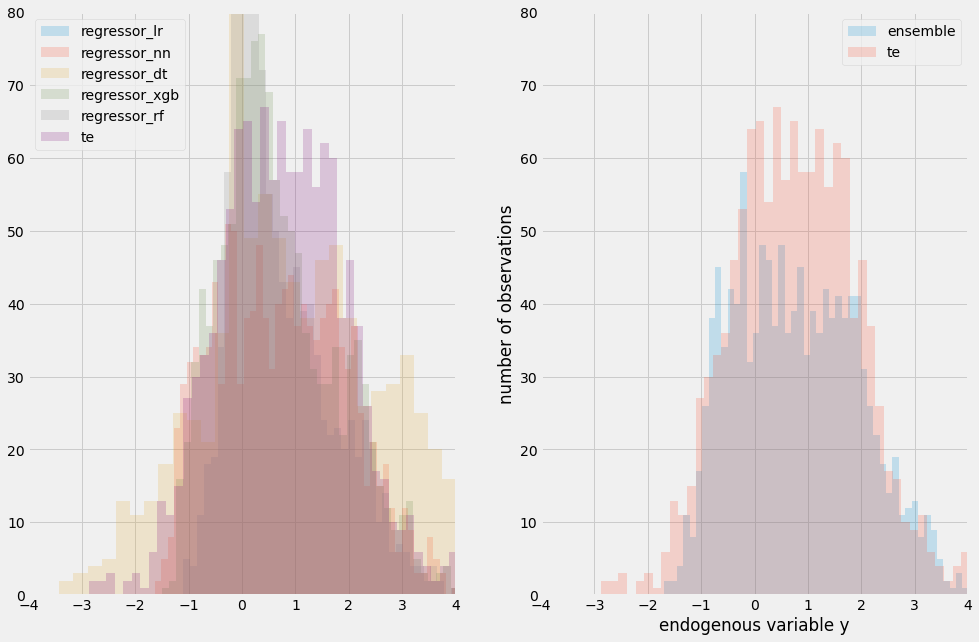

In [3]:
ensemble = SuperLearner(scorer=mean_squared_error, random_state=42)
ensemble.add([x for x in regressors.values()])
ensemble.add_meta(regressors['regressor_nn'])
e_preds_rand, tau_rand_test = simple_model.create_simple_ml_model(X_rand, y_rand, w_rand, tau_rand, ensemble)

plt.figure(figsize=(15, 10))
simple_model.multilayer_hist(rand_preds, tau_rand_test, 121)
simple_model.multilayer_hist({'ensemble':e_preds_rand}, tau_rand_test, 122)

plt.xlabel('endogenous variable y')
plt.ylabel('number of observations')
plt.show()

In [4]:
stacking_helpers.show_MSE_r_square(rand_preds, tau_rand_test, e_preds_rand)

,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
MSE,1.401305,0.074213,1.900713,0.241666,0.344126,0.120217


,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
R-Squared,-0.001035,0.946985,-0.357792,0.827363,0.754171,0.914122


## II.2. Difficult nuisance components, easy treatment effect - the ensemble

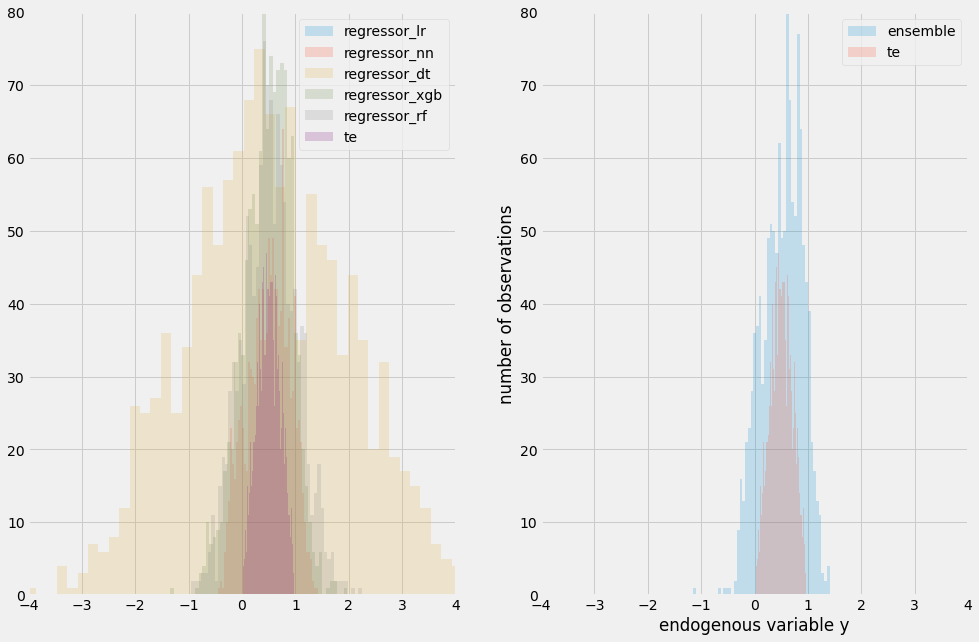

In [5]:
e_preds, tau_easy_test = simple_model.create_simple_ml_model(X_easy, y_easy, w_easy, tau_easy, ensemble)

plt.figure(figsize=(15, 10))
simple_model.multilayer_hist(easy_preds, tau_easy_test, 121)
simple_model.multilayer_hist({'ensemble':e_preds}, tau_easy_test, 122)

plt.xlabel('endogenous variable y')
plt.ylabel('number of observations')
plt.show()

In [6]:
stacking_helpers.show_MSE_r_square(easy_preds, tau_easy_test, e_preds)

,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
MSE,0.064159,0.038377,2.222021,0.126309,0.181738,0.041961


,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
R-Squared,-0.490018,0.10875,-50.60386,-1.933382,-3.220664,0.02551


## II.3. Easy propensity and a difficult baseline - the ensemble
finaly try the difficult baseline below. how do the models do when the treatment effect is 1, while the nuisance variables are highly confounded and mode difficult to estimate than the propensity score?

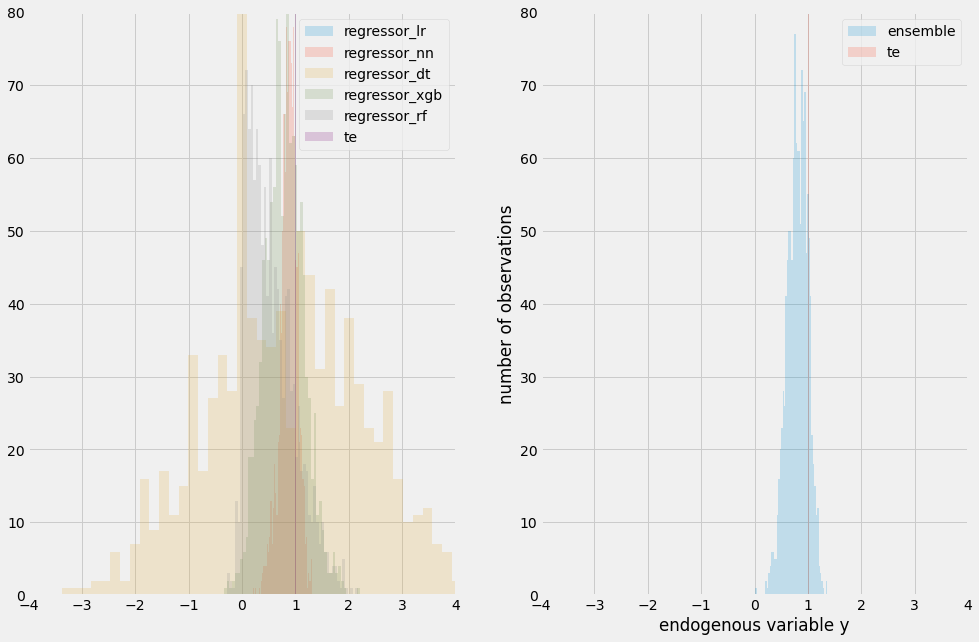

In [7]:
e_preds_difficult, tau_difficult_test = simple_model.create_simple_ml_model(X_difficult, y_difficult, w_difficult, tau_difficult, ensemble)

plt.figure(figsize=(15, 10))
simple_model.multilayer_hist(difficult_preds, tau_difficult_test, 121)
simple_model.multilayer_hist({'ensemble':e_preds_difficult}, tau_difficult_test, 122)

plt.xlabel('endogenous variable y')
plt.ylabel('number of observations')
plt.show()

In [8]:
stacking_helpers.show_MSE_r_square(difficult_preds, tau_difficult_test, e_preds_difficult)

,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
MSE,0.006444,0.041317,1.87192,0.17601,0.40221,0.076023


,regressor_lr,regressor_nn,regressor_dt,regressor_xgb,regressor_rf,stacking
R-Squared,0.0,0.0,0.0,0.0,0.0,0.0


# CONCLUSIONS TO THE FIRST SIMULATIONS?
so now that we have more or less a framework for the simple case of predicting treatment effects and obviously stacking does work ok
we can look at other ways to try stacking while incorporating double machine learning..

We can implement a psedo-stacking methodology on the R learner.
The difficulty in stacking with the libraries provided by the R learner

the pipeline for stacking can take many forms when esitmating treatment effects.

also need to mention when we talk about each of the datasets : what is the best possible outcome we can expect from any model? each dataset has its data generating function with more or less randomness introduced.


#III. A Different Proposal for Stacking to Estimate Treatment Effects
we can use this to stack estimates exactly as in Grimmer, and compare them to the R learners/DML learnings (also stacked) as in Nie, Wager
this would answer the questions:
 - how does stacking **without** double machine learning compare to the R learner on its own? Is there an advantage to using (the best..) R learner over simple stacking? and what kind of libraries are already available for such a pipeline?
 - how much can stacking help if we do not (can not) estimate propensity scores or distinct nuisance functions in the dataset?
 - how does stacking an R learner compare to (the best) single DML model?

As mentioned in part II, the S learner does not explicitly account for propensity scores, or for the 'nuisance function' separate from the treatment effect.
the R learner, on the other hand, is a two-step algorithm which first estimates the propensity score in order to extract the objective function which we would like to know, namely, the treatment effect itself.
Nie and Wager expand on this methodology by suggesting that researchers may use some 'out of the box models' to estimate the objective funcion, and then stack them for the best results. Indeed, if the objective funciton has been isolated from confounding propensity score distribution, then stacking should provide a greater advantage than any one model alone.

The approach that we will take in the next simulations have approximately the same underlying idea. We use the `causalml` library to estimate the propensity score of each observation in a synthetic dataset, and then predict using different estimators fed to the R learner class.
We then use sample ridge regression to estimate the best weighted average given the true treatment effect.
(NOTING HERE HOWEVER, THAT THIS IS A BIT WEIRD, AS IN REAL LIFE WE NEVER HAVE THE TRUE TREATMENT EFFECT)

In Grimmer et al. the weighted average of models which they estimate has the further constraints that the weights must all be positive, and that the sum of all weights must equal one. We, on the other hand, use regularized OLS to estimate a final stacking model.

## 1. Randomized trial - R learner vs T learner
As always, we begin with the most ideal setup, the randomized trial, and generate predictions by several R learners and T learners

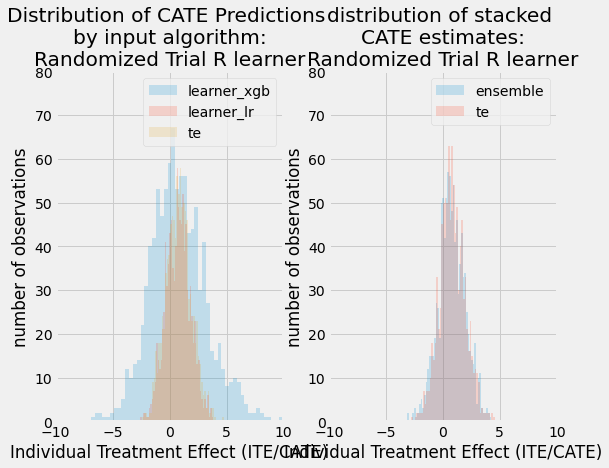

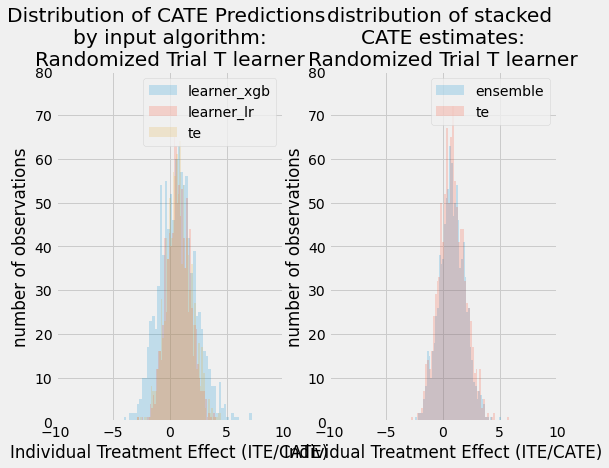

In [9]:
from data_gen import *

predictions_R = generate_predicitons_by_learner(estimators_R)
predictions_T = generate_predicitons_by_learner(estimators_T)

pred_R = predictions_R['predictions_randomized_trial']
pred_R_test = predictions_R['predictions_randomized_trial_test']

plt.figure(figsize=(8,6))
stacking_helpers.fit_and_eval_learners(pred_R, pred_R_test, 'Randomized Trial R learner')
plt.show()

pred_T = predictions_T['predictions_randomized_trial']
pred_T_test = predictions_T['predictions_randomized_trial_test']

plt.figure(figsize=(8,6))
stacking_helpers.fit_and_eval_learners(pred_T, pred_T_test, 'Randomized Trial T learner')
plt.show()

some commentary on what we are looking at above  etc. etc. etc.
## 2. Difficult nuisance components, easy treatment effect - R learner vs T learner

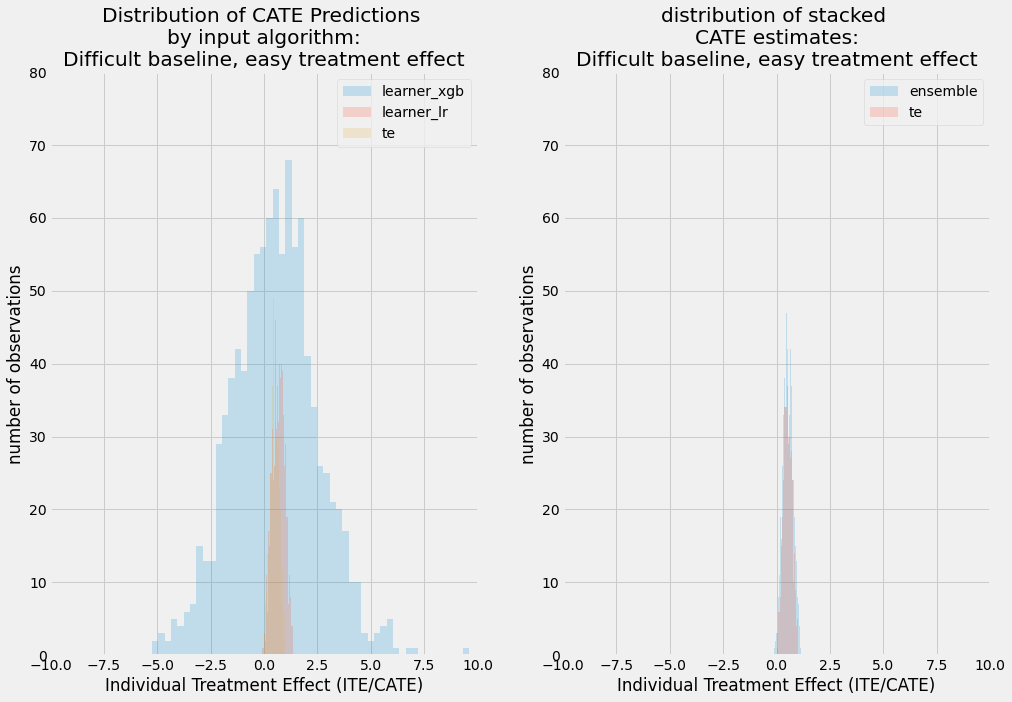

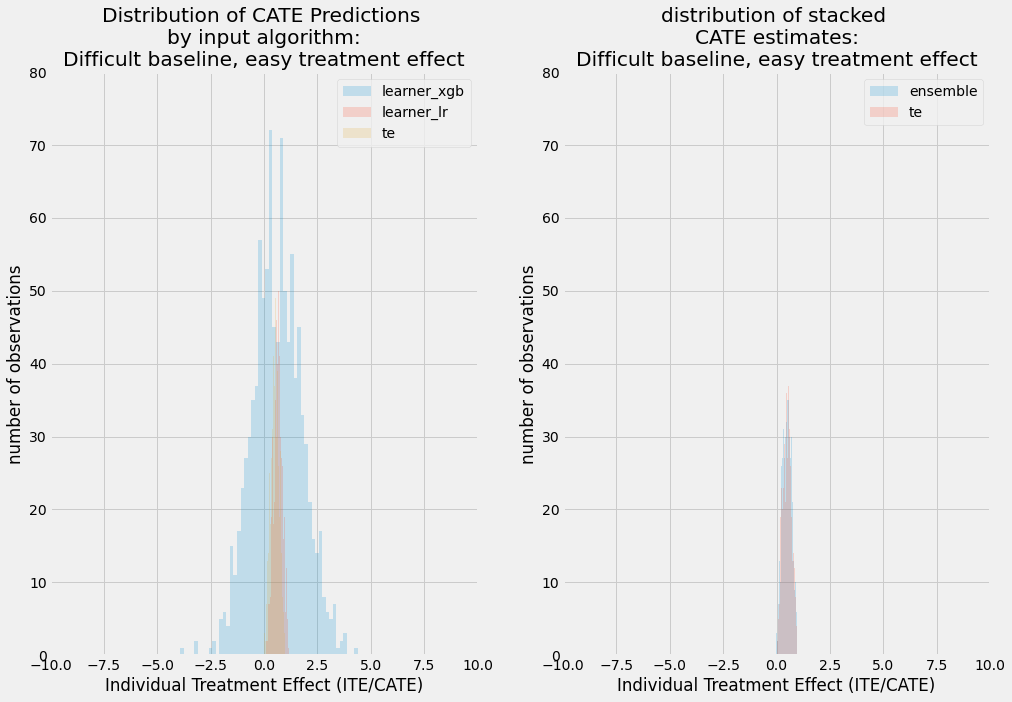

In [10]:
pred_R = predictions_R['predictions_easy_treatment']
pred_R_test = predictions_R['predictions_easy_treatment_test']


pred_T = predictions_T['predictions_easy_treatment']
pred_T_test = predictions_T['predictions_easy_treatment_test']

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_R, pred_R_test, 'Difficult baseline, easy treatment effect')
plt.show()

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_T, pred_T_test, 'Difficult baseline, easy treatment effect')
plt.show()

again some commentary on what we are looking at above  etc. etc. etc. ...

## 3. Easy propensity and a difficult baseline - R learner vs T learner

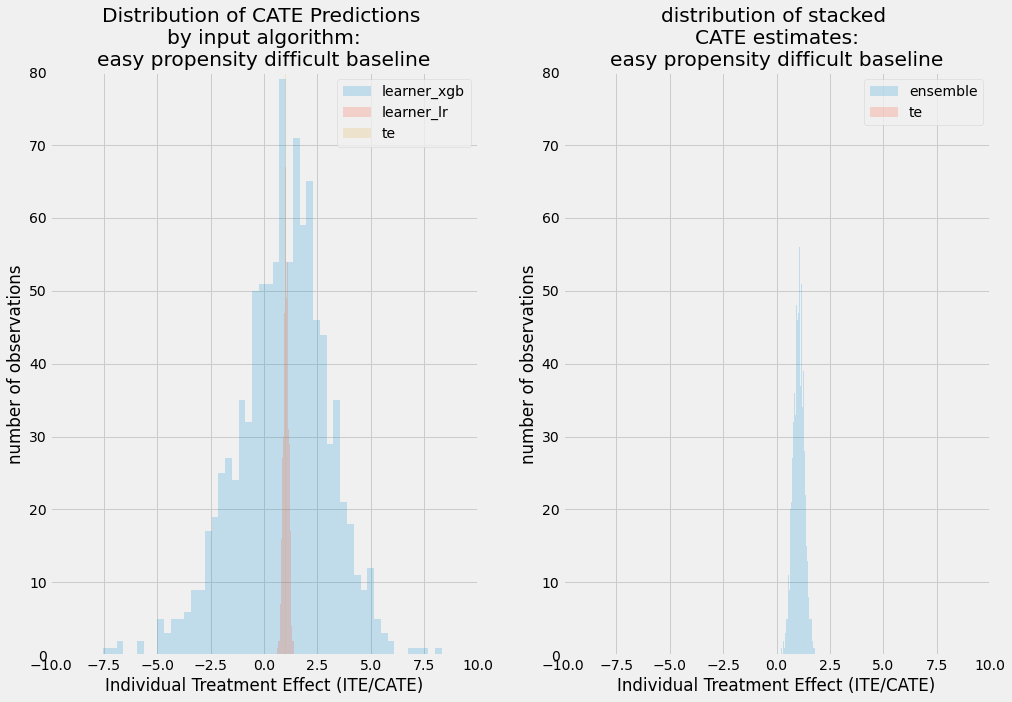

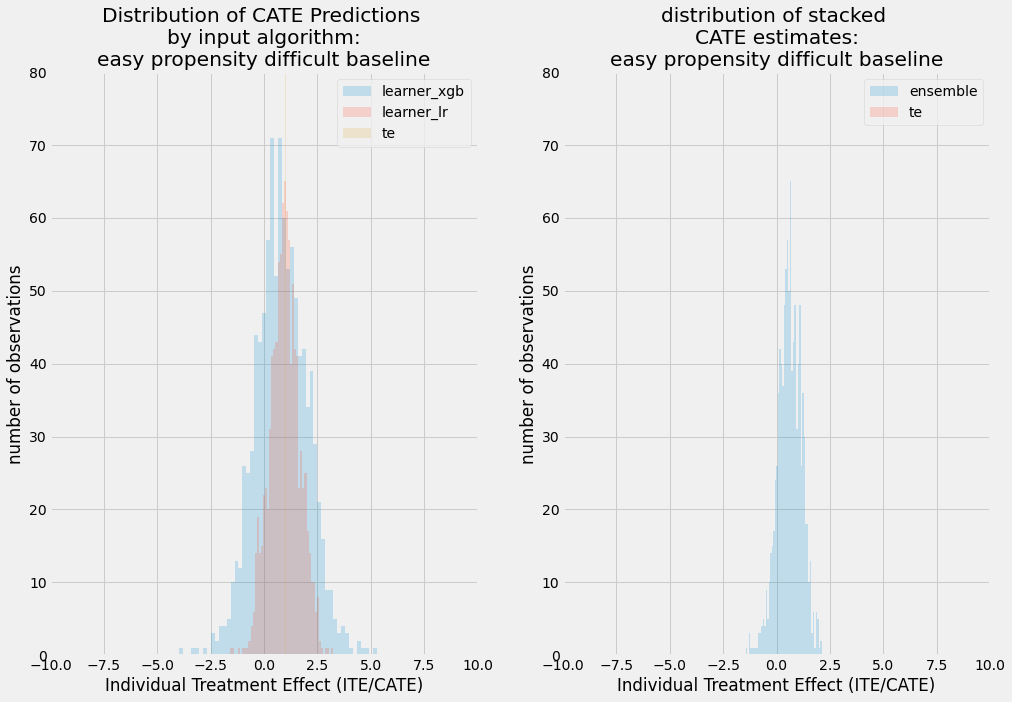

In [11]:
pred_R = predictions_R['predictions_easy_propensity']
pred_R_test = predictions_R['predictions_easy_propensity_test']

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_R, pred_R_test, 'easy propensity difficult baseline')

plt.show()

pred_T = predictions_T['predictions_easy_propensity']
pred_T_test = predictions_T['predictions_easy_propensity_test']

plt.figure(figsize=(15,10))
stacking_helpers.fit_and_eval_learners(pred_T, pred_T_test, 'easy propensity difficult baseline')

plt.show()

## still to do :

* figure out if all situations here are interesting, maybe just keep r learner for the dataset that the 'simple' version did the worst on.
* report MSE and R squared or something else to evaluate
* look at the OLS estimates, CI, SE for the 'stacking' models in the second part.
* write a readme
* probably do some renaming for the packages and functions in them.